# Breast Cancer Detection from Ultrasound images using CNN

## Topic

In this notebook I will be dealing with ultrasound pictures classification. The task is to be able to tell from a scan pictures whether or not a tumor is benign or cancerous. I will be using a convolutional network to classify the images and will try to achieve an accuracy abobe 80%.
So let's get started !



## Objective

- Detect the existance of breast cancer from ultrasound images

## Summary


- Importing Libraries
- The Dataset
- Creating the transforms and data loaders
- Some Dataviz
- Creating the classifier
- Training and validation
- Testing the model
- Evaluation metrics
- Trying out the model
- Conclusion

### Importing Libraries

In [84]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import PIL
from PIL import Image
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
from os import listdir
from torchvision.io import read_image
import torchvision.transforms as T
import numpy as np
from glob import glob
import shutil
import cv2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


### The Dataset 

In [3]:
positive = glob(r'C:\Users\imane\Downloads\archive (18)\ultrasound breast classification\train\benign\*')

In [4]:
im = cv2.imread(positive[58])
print(im.shape)

(224, 224, 3)


In [5]:
im = cv2.imread(positive[98])
print(im.shape)

(224, 224, 3)


In [6]:
files = glob(r'C:\Users\imane\Downloads\archive (18)\ultrasound breast classification\train\*')
files

['C:\\Users\\imane\\Downloads\\archive (18)\\ultrasound breast classification\\train\\benign',
 'C:\\Users\\imane\\Downloads\\archive (18)\\ultrasound breast classification\\train\\malignant']

In [7]:
classes = ["benign", "malignant"]
classes

['benign', 'malignant']

In the above, I imported the dataset and looked at a couple of image sizes, I also made the classes list to be used later during dataviz.

### Creating the transforms and data loaders

In [8]:
data_dir = r'C:\Users\imane\Downloads\archive (18)\ultrasound breast classification'

train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.RandomRotation(60),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [9]:
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/val', transform=test_transforms)

In [10]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [11]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [12]:
batch_size = 20
train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size,
                                          sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size,
                                          sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size)

In [13]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() 
images.shape

(20, 3, 224, 224)

Then I created train and test transforms which specify keeping the size of 224 by 224, make random rotation and flip (for the train set only), transform the pictures to tensors and then normalize them. Then I kept 20% of the train data for validation and created the data loaders.

### Some Dataviz

In [14]:
def imshow(img):
    img = img / 2 + 0.5 
    plt.imshow(np.transpose(img, (1, 2, 0)))

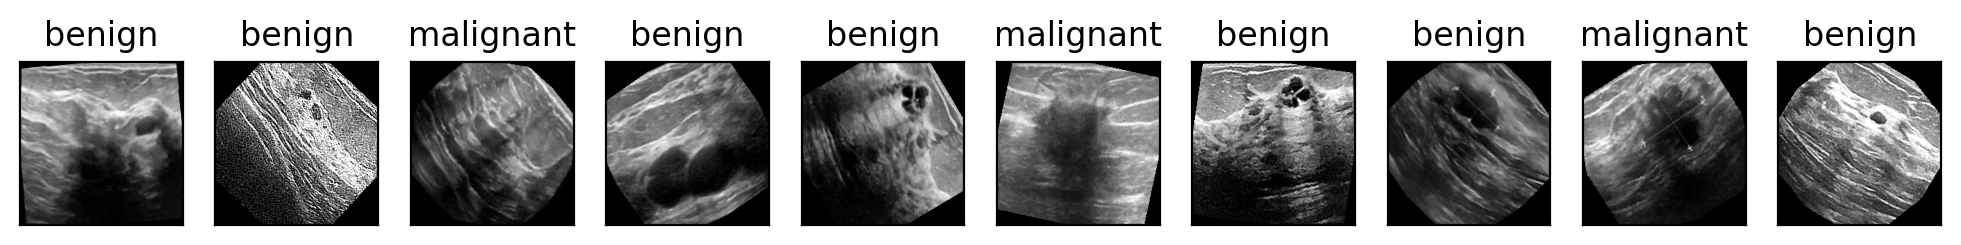

In [15]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 20, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

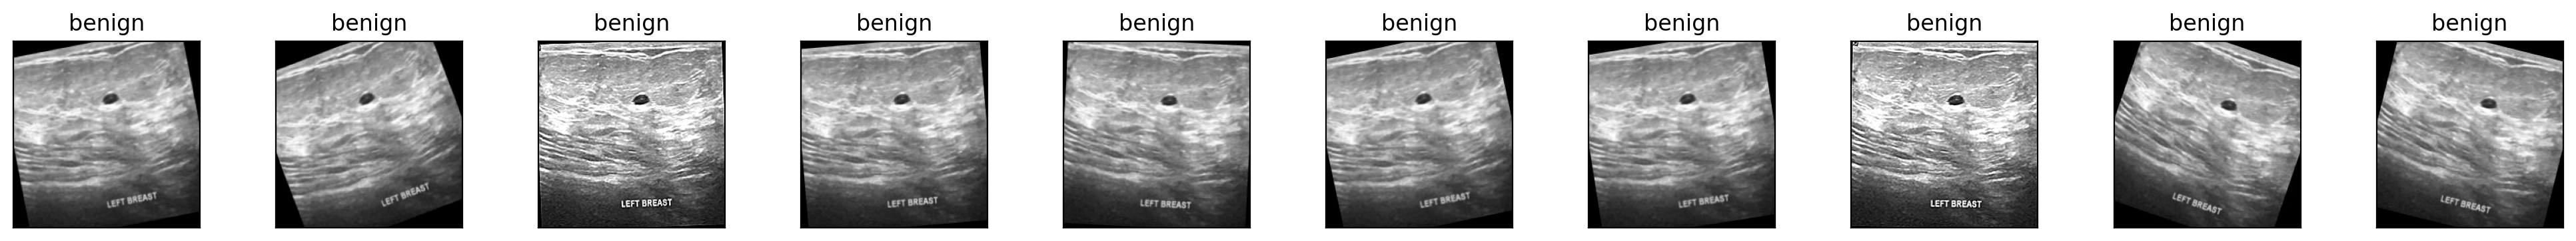

In [16]:
images, labels = next(iter(test_loader))
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

Then I created a simple function to unormalize and plot the pictures with their labels.

### Creating the Classifier

In [53]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 48, 3, padding =1)
        self.conv4 = nn.Conv2d(48, 64, 3, padding =1)
        
        self.pool1 = nn.MaxPool2d(4,4)
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(7*7*64, 922)
        self.fc2 = nn.Linear(922, 2)
        
        self.dropout = nn.Dropout(p= 0.25)
        self.batchn1 = nn.BatchNorm2d(16)
        self.batchn2 = nn.BatchNorm2d(32)
        self.batchn3 = nn.BatchNorm2d(48)
        self.batchn4 = nn.BatchNorm2d(64)
        
        
    def forward(self, x):
        
        x = self.pool1(F.relu(self.batchn1(self.conv1(x))))
        x = self.pool2(F.relu(self.batchn2(self.conv2(x))))
        x = self.pool2(F.relu(self.batchn3(self.conv3(x))))
        x = self.pool2(F.relu(self.batchn4(self.conv4(x))))

        x = torch.flatten(x, 1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.log_softmax(self.fc2(x), dim = 1)
        
        return x

In the above I built a classifier that has 4 convolutional layers, the first of which is followed by a 4 by 4 pooling and the rest followed by 2 by 2 pooling, then two fully connected layers with a dropout probability of .25 and batch normalization after after every conv layer.

In [54]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr= 0.0005)

I imported the model and chose the negative log likelihood loss as a criterion of loss and a gradient descent with a learning rate of .0005 as an optimizer.

In [55]:
print(model)

Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=922, bias=True)
  (fc2): Linear(in_features=922, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (batchn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

### Training and Validation

In [56]:
epochs = 200

valid_loss_min = np.Inf
train_accuracy, val_accuracy = [],[]

for epoch in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    t_acc = 0.0
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        train_loss += loss.item()*images.size(0)
        ps = torch.exp(logits)
        top_k, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        t_acc += equals.sum().item()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        model.eval()
        v_acc = 0.0
        for images, labels in valid_loader:
            logits = model(images)
            loss = criterion(logits, labels)
            valid_loss += loss.item()*images.size(0)
            ps = torch.exp(logits)
            top_k, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            v_acc += equals.sum().item()
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_accuracy.append(t_acc/len(train_loader.sampler))
    val_accuracy.append(v_acc/len(valid_loader.sampler))
    
    print("Epoch ", epoch+1, "train loss ", train_loss, "validation loss ", valid_loss)
    
    if valid_loss <= valid_loss_min:
        print("validation loss decreased", valid_loss_min, "---->", valid_loss)
        print("Saving the model")
        torch.save(model.state_dict(), "model_cnn.pt")
        valid_loss_min = valid_loss

Epoch  1 train loss  0.6498875712808615 validation loss  0.6082592098270753
validation loss decreased inf ----> 0.6082592098270753
Saving the model
Epoch  2 train loss  0.5818663497248728 validation loss  0.570514578585704
validation loss decreased 0.6082592098270753 ----> 0.570514578585704
Saving the model
Epoch  3 train loss  0.5470845497445812 validation loss  0.5362499923303549
validation loss decreased 0.570514578585704 ----> 0.5362499923303549
Saving the model
Epoch  4 train loss  0.5220166949485568 validation loss  0.524306616019997
validation loss decreased 0.5362499923303549 ----> 0.524306616019997
Saving the model
Epoch  5 train loss  0.5011173483221258 validation loss  0.4970940008291255
validation loss decreased 0.524306616019997 ----> 0.4970940008291255
Saving the model
Epoch  6 train loss  0.4865894022082284 validation loss  0.4870962232479841
validation loss decreased 0.4970940008291255 ----> 0.4870962232479841
Saving the model
Epoch  7 train loss  0.47442599755120757 va

Epoch  66 train loss  0.2142264393978561 validation loss  0.20500867598525405
validation loss decreased 0.21612470024578084 ----> 0.20500867598525405
Saving the model
Epoch  67 train loss  0.2074482080204065 validation loss  0.23476897520130788
Epoch  68 train loss  0.20680883116234108 validation loss  0.19470780976782298
validation loss decreased 0.20500867598525405 ----> 0.19470780976782298
Saving the model
Epoch  69 train loss  0.20708122961228864 validation loss  0.2121805707664124
Epoch  70 train loss  0.2021319959195061 validation loss  0.20955713796334655
Epoch  71 train loss  0.20121856843004163 validation loss  0.18461948726613142
validation loss decreased 0.19470780976782298 ----> 0.18461948726613142
Saving the model
Epoch  72 train loss  0.20656871766278836 validation loss  0.20188002209268047
Epoch  73 train loss  0.19363882982563793 validation loss  0.18448735422839813
validation loss decreased 0.18461948726613142 ----> 0.18448735422839813
Saving the model
Epoch  74 train 

Epoch  145 train loss  0.08604062912704837 validation loss  0.0889948813459312
Epoch  146 train loss  0.08543849651423915 validation loss  0.07414549499410432
validation loss decreased 0.0751635026022016 ----> 0.07414549499410432
Saving the model
Epoch  147 train loss  0.08303809048567497 validation loss  0.0795769528454274
Epoch  148 train loss  0.08663449567583002 validation loss  0.07199405276263046
validation loss decreased 0.07414549499410432 ----> 0.07199405276263046
Saving the model
Epoch  149 train loss  0.08456839650069577 validation loss  0.08378737194271953
Epoch  150 train loss  0.07935160858679695 validation loss  0.08361165688699657
Epoch  151 train loss  0.08521526922776908 validation loss  0.07576817695512789
Epoch  152 train loss  0.07846295106286823 validation loss  0.06355659027072616
validation loss decreased 0.07199405276263046 ----> 0.06355659027072616
Saving the model
Epoch  153 train loss  0.07885285421813487 validation loss  0.06785728844044499
Epoch  154 train

In [57]:
model.load_state_dict(torch.load("model_cnn.pt"))

<All keys matched successfully>

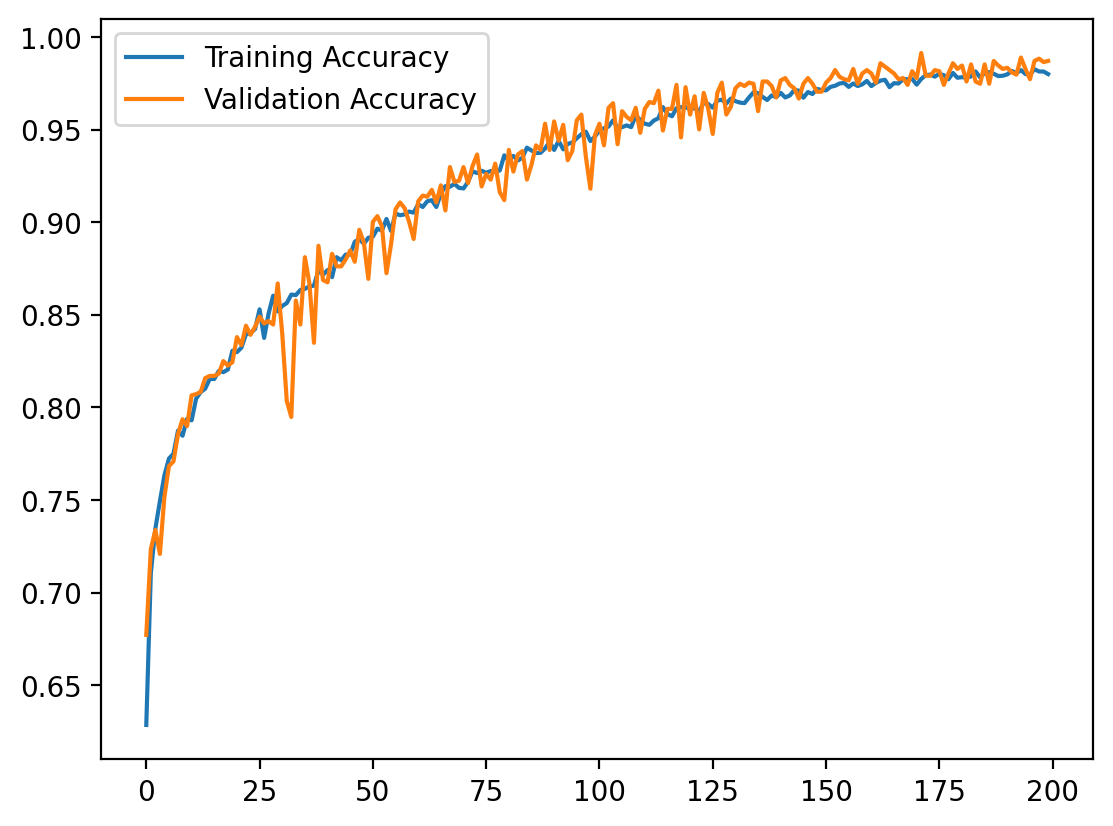

In [58]:
plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.legend()

The training was done over 200 epochs ( I chose this number after experiment with different numbers), and I kept the model with the least validation loss. I also kept track of traing vs validation accuracy and the plot shows that these two are improving in the same pace which suggests the absence of overfitting.

### Testing the model

In [64]:
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()

for data, target in test_loader:

    output = model(data)
    loss = criterion(output, target)

    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)  
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) 
    for i in range(len(target)):

        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.250644

Test Accuracy of benign: 91% (458/500)
Test Accuracy of malignant: 93% (373/400)

Test Accuracy (Overall): 92% (831/900)


### Evaluation metrics

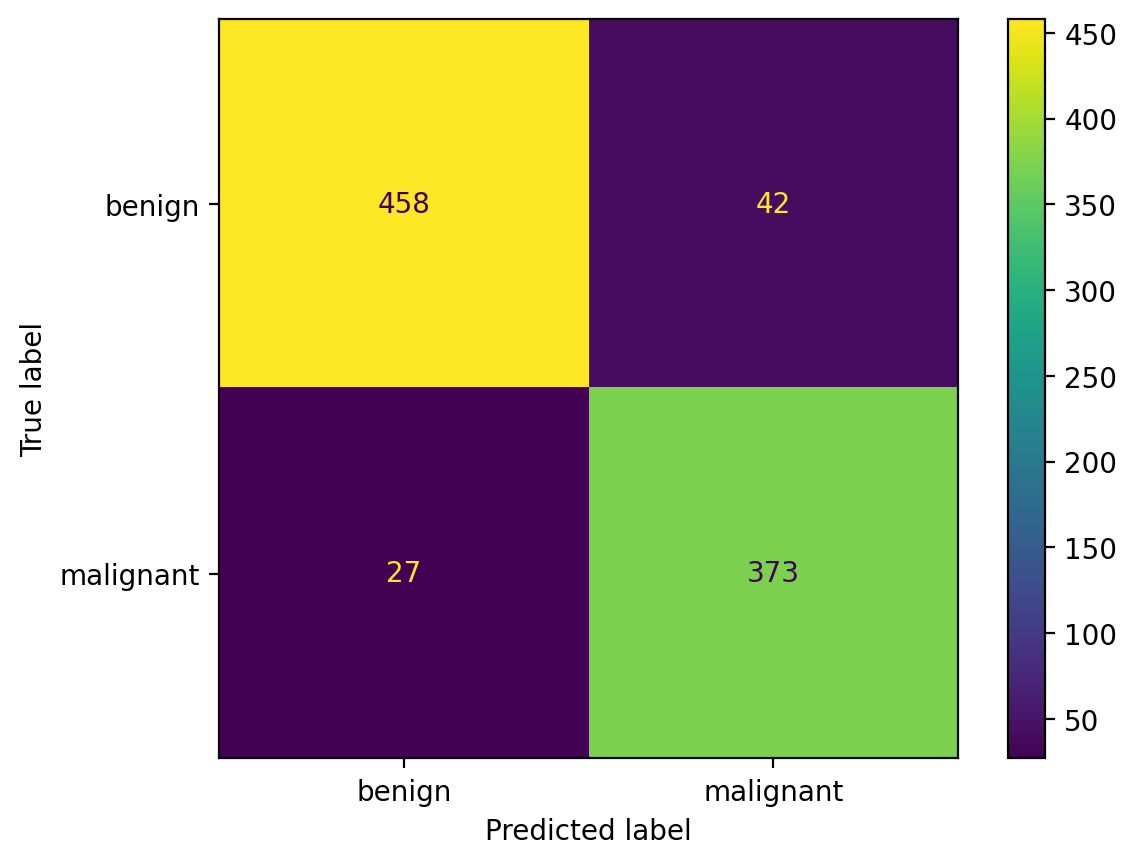

In [86]:
target = []
predictions = []
model.eval()
with torch.no_grad():
    for data, label in test_loader:
        logits = model(data)
        logits = (torch.max(torch.exp(logits), 1)[1]).data.numpy()
        predictions.extend(logits)
        label = label.data.numpy()
        target.extend(label)
cm = confusion_matrix(target, predictions)
dis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
dis.plot()
plt.show()

In [87]:
print(classification_report(target, predictions, target_names=classes))

              precision    recall  f1-score   support

      benign       0.94      0.92      0.93       500
   malignant       0.90      0.93      0.92       400

    accuracy                           0.92       900
   macro avg       0.92      0.92      0.92       900
weighted avg       0.92      0.92      0.92       900



Nest I tried my model on the test set which it has never seen before. The results were quite impressive (an overall accuracy of 92%) eventhough the model is more accurate on benign images (target 0) then malignant (target 1).
The confusion matrix show the true labels vs the predictions, the False Negatives are 27 while the False Positivesis 42 which is great because it means that the number of times the model pridicts nothing when there is cancer is only 27 compared to the number of times the model says there is cancer while there is not.
The Classification report shows that the model has better precision on benign photos but the recall is better for malignant photos.

### Trying out the model

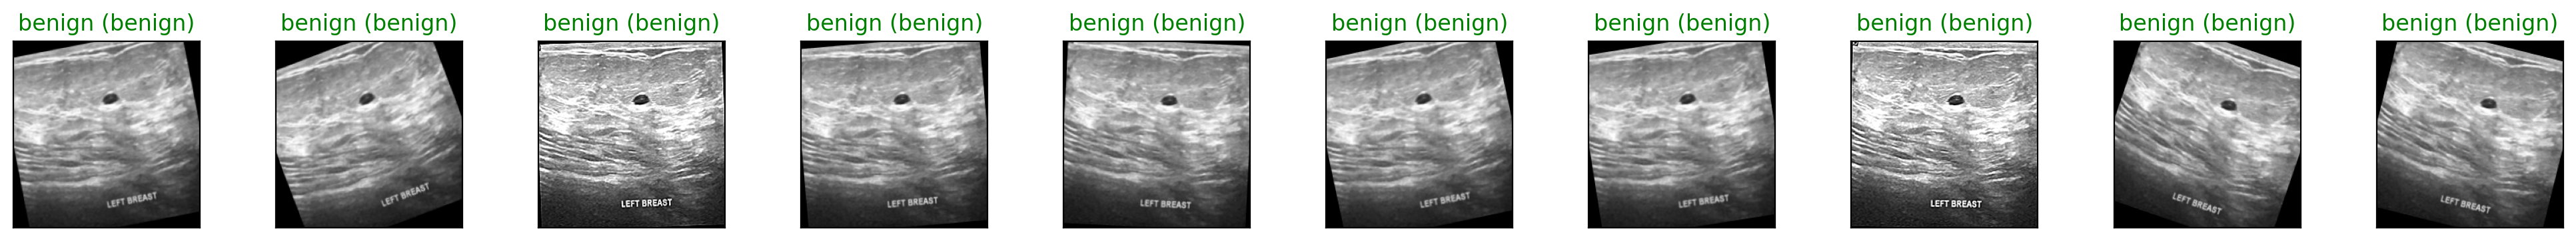

In [88]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) 

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

### Conclusion

In this notebook I have experimented with binary image classification, the task was to build a model that is able to differenciate between cancerous and non cancerous images of breast ultrasounds. The artchitecture that I chose was a CNN with four convoluational layers and two fully connected layers, and the training was set to 200 epochs. The results of the model were quite good seen as it reached an accuracy of 92%, and its performance on detecting cancer is slightly better than its performance detecting nothing.